In [11]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 21.8 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.2 MB/s eta 0:00:00


#### Count frames


In [9]:
import cv2
import sys

def count_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Print video information
    print(f"\nVideo: {video_path}")
    print(f"Dimensions: {width}x{height}")
    print(f"FPS: {fps}")
    print(f"Frame count from metadata: {frame_count}")
    
    # Count frames manually to verify
    manual_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        manual_count += 1
    
    print(f"Actual frame count: {manual_count}")
    
    # Release resources
    cap.release()
    
    return manual_count

if __name__ == "__main__":
    # Get video paths from command line or use defaults
    video1_path = "Video_0_L.mp4"  # Replace with your first video path
    video2_path = "Video_0_R.mp4"  # Replace with your second video path
    
    print("Comparing frame counts between videos...")
    
    frames1 = count_frames(video1_path)
    frames2 = count_frames(video2_path)
    
    if frames1 is not None and frames2 is not None:
        print("\nComparison:")
        print(f"Video 1 frames: {frames1}")
        print(f"Video 2 frames: {frames2}")
        print(f"Difference: {abs(frames1 - frames2)} frames")

    video1_path = "Video_1_L.mp4"  # Replace with your first video path
    video2_path = "Video_1_R.mp4"  # Replace with your second video pat

    frames1 = count_frames(video1_path)
    frames2 = count_frames(video2_path)
    
    if frames1 is not None and frames2 is not None:
        print("\nComparison:")
        print(f"Video 1 frames: {frames1}")
        print(f"Video 2 frames: {frames2}")
        print(f"Difference: {abs(frames1 - frames2)} frames")

Comparing frame counts between videos...

Video: Video_0_L.mp4
Dimensions: 1080x1920
FPS: 29.87874321698935
Frame count from metadata: 446
Actual frame count: 446

Video: Video_0_R.mp4
Dimensions: 1080x1920
FPS: 29.88034188034188
Frame count from metadata: 437
Actual frame count: 437

Comparison:
Video 1 frames: 446
Video 2 frames: 437
Difference: 9 frames

Video: Video_1_L.mp4
Dimensions: 1080x1920
FPS: 29.750346740638
Frame count from metadata: 429
Actual frame count: 429

Video: Video_1_R.mp4
Dimensions: 1080x1920
FPS: 29.84775641025641
Frame count from metadata: 447
Actual frame count: 447

Comparison:
Video 1 frames: 429
Video 2 frames: 447
Difference: 18 frames


#### 3D scan

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import time

# Load the stereo images
left_img = cv2.imread('left_image_1.jpg')
right_img = cv2.imread('right_image_1.jpg')

# Check if images were loaded successfully
if left_img is None or right_img is None:
    print("Error: Could not load images. Please check the file paths.")
else:
    print(f"Loaded images: Left {left_img.shape}, Right {right_img.shape}")

# Camera parameters based on the corrected specifications
image_width = left_img.shape[1]
image_height = left_img.shape[0]
pixel_size_mm = 2.7e-3  # 2.7μm = 0.0027mm
focal_length_mm = 2.88  # corrected EFL
fov_horizontal = 110    # FOV(H) in degrees
fov_vertical = 60       # FOV(V) in degrees
fov_diagonal = 130      # FOV(D) in degrees
distortion = -15        # TV distortion percentage
optical_distortion = -152  # Optical distortion percentage
nominal_baseline = 120  # 12cm = 120mm

# Calculate focal length in pixels
focal_length_px = focal_length_mm / pixel_size_mm

print("\nCamera Specifications:")
print(f"Image dimensions: {image_width}x{image_height}")
print(f"Sensor: JX-F37 1/3\" 1920x1080, 2.7μm pixel size")
print(f"Focal length: {focal_length_mm}mm = {focal_length_px:.1f}px")
print(f"Field of View: {fov_diagonal}° diagonal, {fov_horizontal}° horizontal, {fov_vertical}° vertical")
print(f"Optical distortion: {optical_distortion}%")
print(f"Nominal baseline: {nominal_baseline}mm")

# Define calibration parameters based on specifications
# For a real calibration, these would be obtained through chessboard calibration
# Here we're approximating based on the given specifications
K_left = np.array([
    [focal_length_px, 0, image_width/2],
    [0, focal_length_px, image_height/2],
    [0, 0, 1]
])

K_right = K_left.copy()  # Assuming identical cameras

# Distortion coefficients - approximate based on the high optical distortion value
# For a wide-angle lens with strong barrel distortion
# k1, k2, p1, p2, k3
# k1, k2, k3 are radial distortion coefficients, p1, p2 are tangential distortion coefficients
# A large negative k1 creates barrel distortion
k1 = -0.3  # Strong barrel distortion
k2 = 0.1   # Secondary radial term
dist_left = np.array([k1, k2, 0, 0, 0], dtype=np.float32)
dist_right = dist_left.copy()  # Assuming identical distortion

# Define the rotation and translation between cameras
# For a standard stereo setup, cameras are side by side (translation in X)
# We'll add small rotations to account for misalignment
R = Rotation.from_euler('xyz', [0.5, 0.5, 0], degrees=True).as_matrix()
T = np.array([-nominal_baseline, 0, 0], dtype=np.float32)  # -120mm in X direction

# Function to downsample image
def downsample_image(img, scale=2):
    return cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))

# Downsample for faster processing
scale = 2
left_small = downsample_image(left_img, scale)
right_small = downsample_image(right_img, scale)

# Adjust calibration for downsampled images
K_left_small = K_left.copy()
K_left_small[0,0] /= scale
K_left_small[1,1] /= scale
K_left_small[0,2] /= scale
K_left_small[1,2] /= scale

K_right_small = K_right.copy()
K_right_small[0,0] /= scale
K_right_small[1,1] /= scale
K_right_small[0,2] /= scale
K_right_small[1,2] /= scale

# Convert to grayscale for processing
left_gray = cv2.cvtColor(left_small, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_small, cv2.COLOR_BGR2GRAY)

print("\nCalibrating and rectifying images...")

# Calculate stereo rectification parameters
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K_left_small, dist_left, K_right_small, dist_right, 
    left_gray.shape[::-1], R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0)

# Compute undistortion and rectification maps
map1x, map1y = cv2.initUndistortRectifyMap(
    K_left_small, dist_left, R1, P1, left_gray.shape[::-1], cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(
    K_right_small, dist_right, R2, P2, right_gray.shape[::-1], cv2.CV_32FC1)

# Apply rectification
left_rectified = cv2.remap(left_gray, map1x, map1y, cv2.INTER_LINEAR)
right_rectified = cv2.remap(right_gray, map2x, map2y, cv2.INTER_LINEAR)

# For visualization, apply rectification to color images
left_rectified_color = cv2.remap(left_small, map1x, map1y, cv2.INTER_LINEAR)
right_rectified_color = cv2.remap(right_small, map2x, map2y, cv2.INTER_LINEAR)

# Display original and rectified images
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(left_small, cv2.COLOR_BGR2RGB))
plt.title('Original Left Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(right_small, cv2.COLOR_BGR2RGB))
plt.title('Original Right Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(left_rectified_color, cv2.COLOR_BGR2RGB))
plt.title('Rectified Left Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(right_rectified_color, cv2.COLOR_BGR2RGB))
plt.title('Rectified Right Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Now let's compare the original and rectified images with horizontal lines
# to visualize the rectification effect
def draw_epipolar_lines(img_left, img_right, n_lines=20):
    h, w = img_left.shape[:2]
    line_interval = h // n_lines
    
    left_lines = img_left.copy()
    right_lines = img_right.copy()
    
    for i in range(n_lines):
        y = i * line_interval
        # Draw horizontal line on both images
        cv2.line(left_lines, (0, y), (w, y), (0, 255, 0), 1)
        cv2.line(right_lines, (0, y), (w, y), (0, 255, 0), 1)
    
    return left_lines, right_lines

# Draw epipolar lines on original and rectified images
orig_left_lines, orig_right_lines = draw_epipolar_lines(left_small, right_small)
rect_left_lines, rect_right_lines = draw_epipolar_lines(left_rectified_color, right_rectified_color)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(orig_left_lines, cv2.COLOR_BGR2RGB))
plt.title('Original Left with Lines')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(orig_right_lines, cv2.COLOR_BGR2RGB))
plt.title('Original Right with Lines')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(rect_left_lines, cv2.COLOR_BGR2RGB))
plt.title('Rectified Left with Lines')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(rect_right_lines, cv2.COLOR_BGR2RGB))
plt.title('Rectified Right with Lines')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Computing disparity map from rectified images...")

# Compute disparity map using the rectified images
# Use StereoSGBM with parameters tuned for wide-angle lens
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,  # More disparities for wider baseline
    blockSize=5,
    P1=8 * 3 * 5**2,
    P2=32 * 3 * 5**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,  # Reduced for wide-angle lens
    speckleWindowSize=100,
    speckleRange=2,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Compute disparity
disparity = stereo.compute(left_rectified, right_rectified).astype(np.float32) / 16.0

# Apply additional filtering to improve disparity map
disparity_filtered = cv2.bilateralFilter(disparity, d=5, sigmaColor=50, sigmaSpace=50)

# Create a nicer visualization of the disparity map
plt.figure(figsize=(12, 10))

# Use a better colormap and normalization for disparity
plt.imshow(disparity_filtered, cmap='jet')
plt.title('Disparity Map from Rectified Images')
plt.colorbar(label='Disparity (pixels)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Now convert disparity to depth
# Get the new projection matrix from stereoRectify
# This contains the adjusted focal length and baseline
print("Converting disparity to depth...")

# Extract baseline and focal length from the Q matrix
baseline = -1.0 / Q[3, 2]  # Baseline in mm
focal_length = Q[2, 3]     # Focal length in pixels

print(f"Calibrated baseline: {baseline:.2f}mm")
print(f"Calibrated focal length: {focal_length:.2f}px")

# Calculate depth map
valid_mask = disparity_filtered > 0
depth = np.zeros_like(disparity_filtered)
depth[valid_mask] = baseline * focal_length / disparity_filtered[valid_mask]

# Clip depth to reasonable values
max_depth = np.percentile(depth[valid_mask], 95)  # Use 95th percentile to avoid outliers
depth = np.clip(depth, 0, max_depth)

# Combined visualization of the rectified left image and depth map
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_rectified_color, cv2.COLOR_BGR2RGB))
plt.title('Rectified Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
depth_vis = plt.imshow(depth, cmap='viridis')
plt.title('Depth Map')
plt.colorbar(depth_vis, label='Depth (mm)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate depth statistics
valid_depths = depth[depth > 0]
min_depth = np.percentile(valid_depths, 5)  # 5th percentile to avoid outliers
max_depth = np.percentile(valid_depths, 95)  # 95th percentile to avoid outliers
mean_depth = np.mean(valid_depths)
median_depth = np.median(valid_depths)

print("\nDepth Statistics:")
print(f"Min depth (5th percentile): {min_depth:.1f}mm = {min_depth/1000:.2f}m")
print(f"Max depth (95th percentile): {max_depth:.1f}mm = {max_depth/1000:.2f}m")
print(f"Mean depth: {mean_depth:.1f}mm = {mean_depth/1000:.2f}m")
print(f"Median depth: {median_depth:.1f}mm = {median_depth/1000:.2f}m")

# Create a visualization with depth contours overlaid on the original image
plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(left_rectified_color, cv2.COLOR_BGR2RGB))
contour = plt.contourf(depth, alpha=0.5, cmap='viridis', levels=20)
plt.colorbar(label='Depth (mm)')
plt.contour(depth, colors='k', alpha=0.3, levels=10)
plt.title('Depth Contours Overlaid on Rectified Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the final disparity and depth maps
cv2.imwrite('calibrated_disparity_map.png', cv2.applyColorMap(
    cv2.convertScaleAbs(disparity_filtered, alpha=255/np.max(disparity_filtered)), cv2.COLORMAP_JET))
cv2.imwrite('calibrated_depth_map.png', cv2.applyColorMap(
    cv2.convertScaleAbs(depth, alpha=255/np.max(depth)), cv2.COLORMAP_VIRIDIS))

print("Calibrated disparity and depth maps saved as PNG files.")

Error: Could not load images. Please check the file paths.


[ WARN:0@0.632] global loadsave.cpp:268 findDecoder imread_('left_image_1.jpg'): can't open/read file: check file path/integrity
[ WARN:0@0.632] global loadsave.cpp:268 findDecoder imread_('right_image_1.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

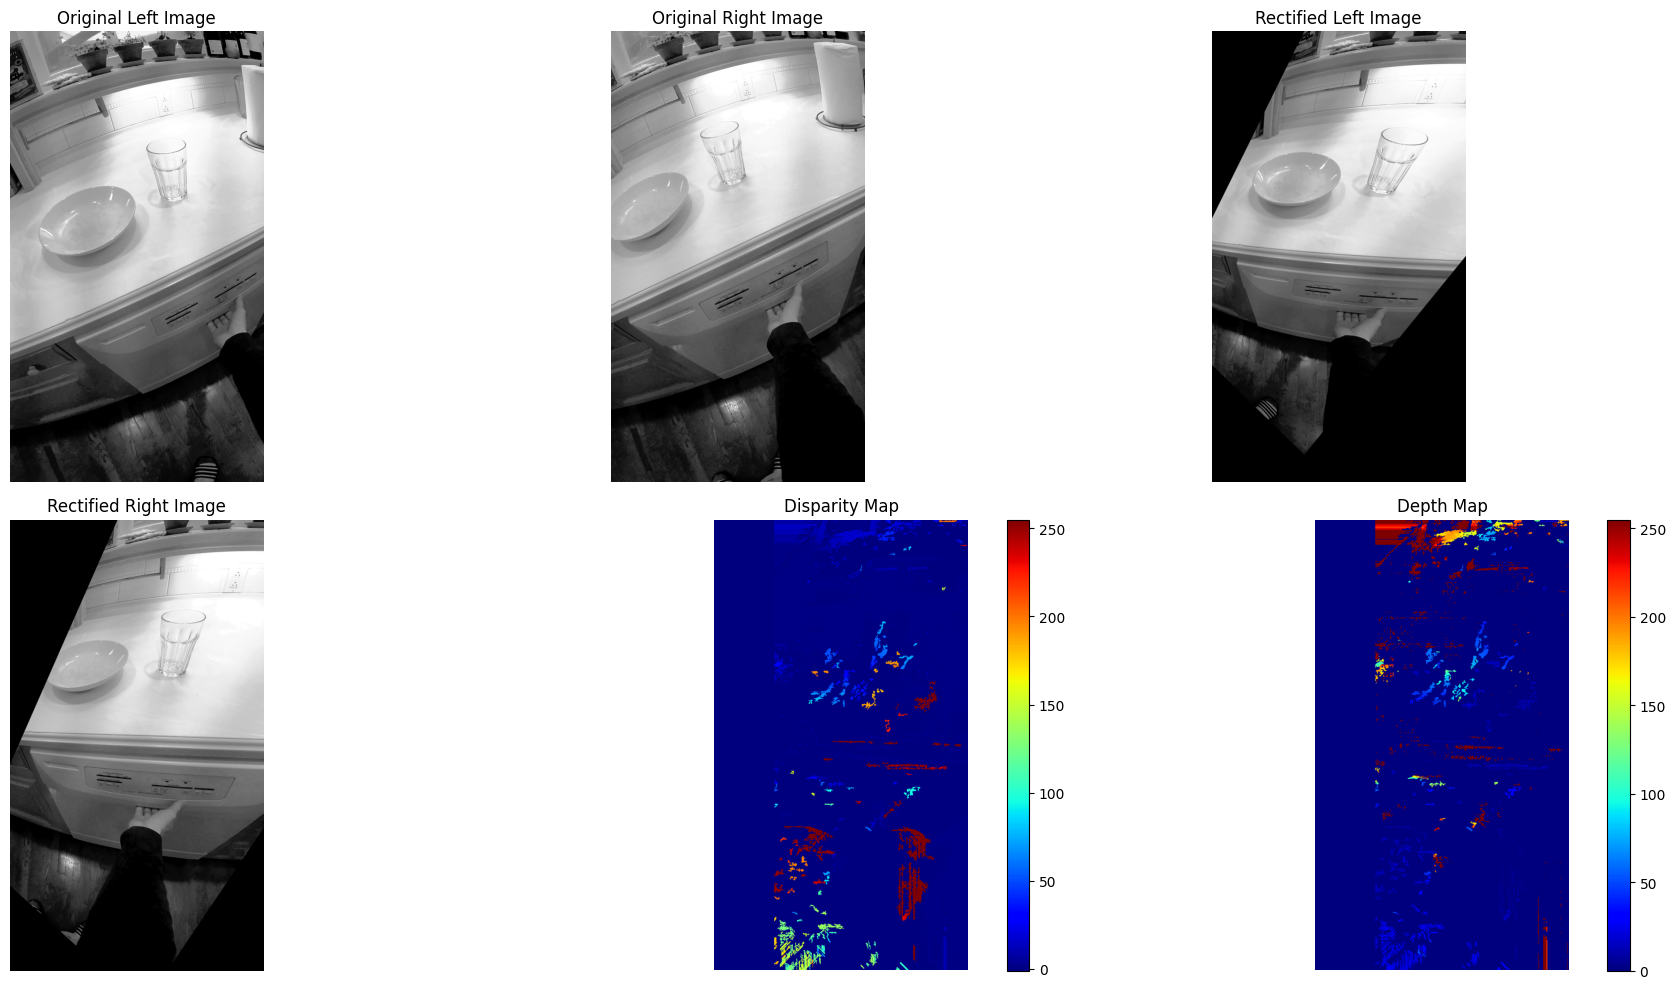

Disparity range: 0.56 to 254.50
Depth range: 232.79mm to 5000.00mm
Valid pixels: 132073 out of 2073600


Preprocessed image size: (768, 432)
Number of good matches: 48


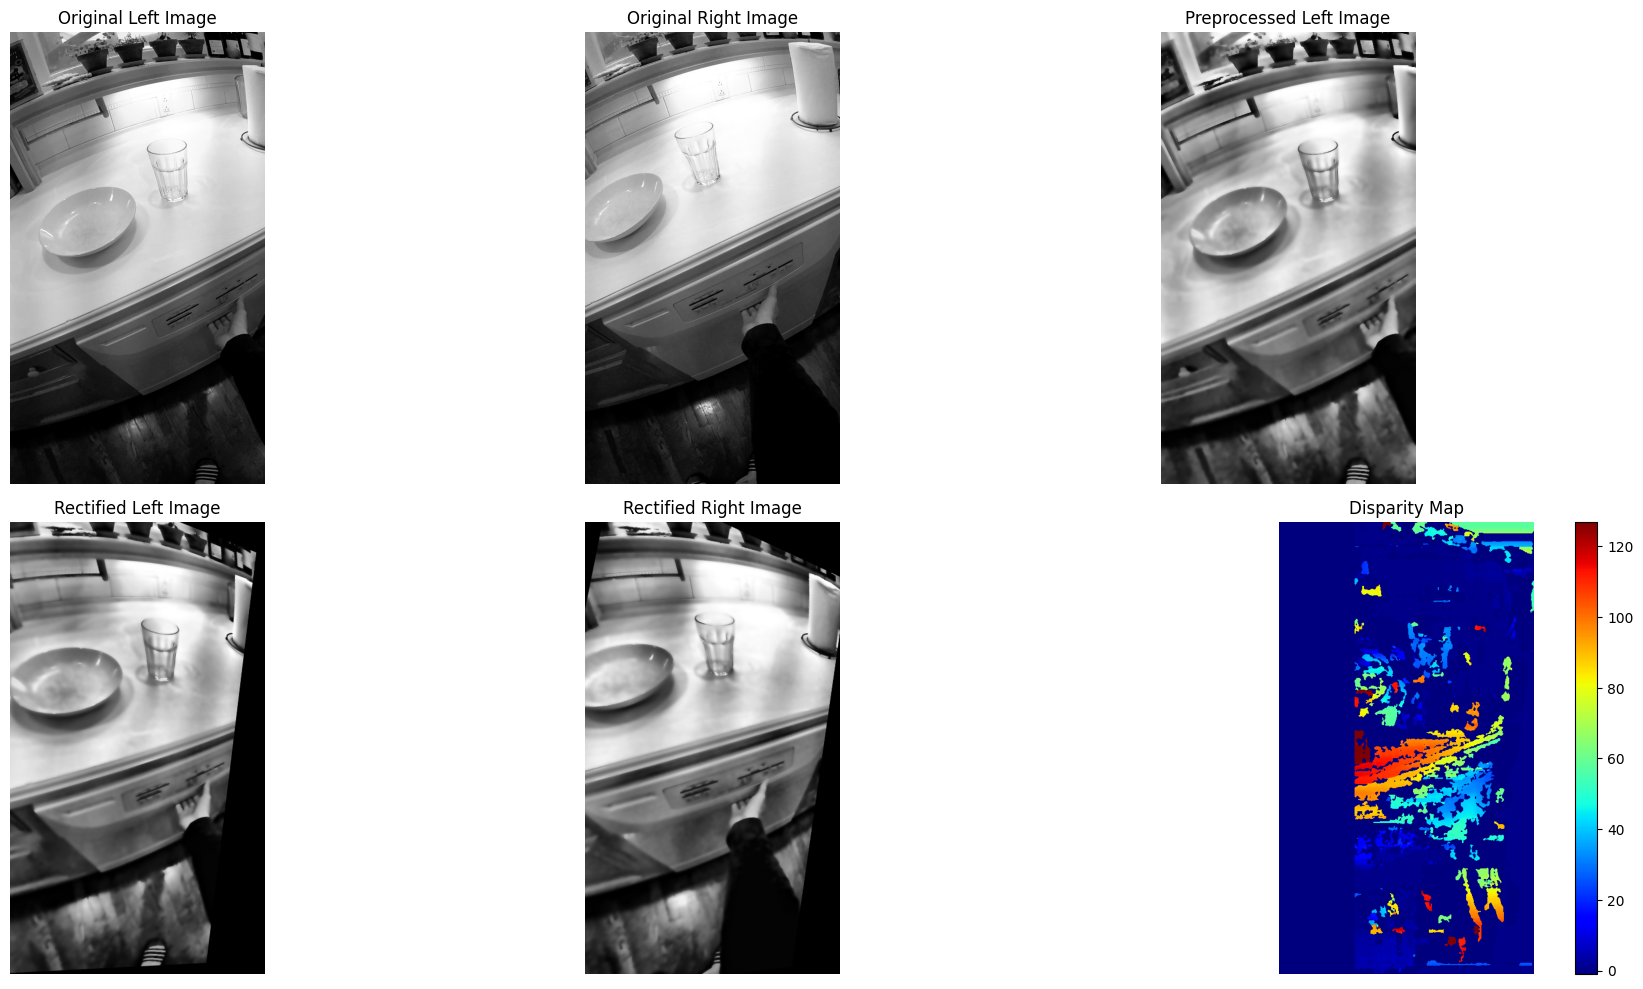

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_and_filter_matches(left_img, right_img):
    # Initialize SIFT detector with lower contrast threshold
    sift = cv2.SIFT_create(contrastThreshold=0.04)
    
    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(left_img, None)
    kp2, des2 = sift.detectAndCompute(right_img, None)
    
    if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
        raise ValueError("Not enough keypoints found in images")
    
    # Use BFMatcher instead of FLANN for more reliable matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    
    # Store all good matches based on Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # Relaxed ratio test
            good_matches.append(m)
    
    if len(good_matches) < 10:
        raise ValueError(f"Not enough matches found: {len(good_matches)}")
    
    # Extract location of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Use RANSAC to filter matches
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Filter matches using the mask
    mask = mask.ravel().tolist()
    filtered_src_pts = src_pts[np.array(mask) == 1]
    filtered_dst_pts = dst_pts[np.array(mask) == 1]
    
    return filtered_src_pts, filtered_dst_pts, good_matches

def preprocess_images(left_img, right_img, scale_factor=0.5):
    # Resize images
    width = int(left_img.shape[1] * scale_factor)
    height = int(left_img.shape[0] * scale_factor)
    dim = (width, height)
    
    left_img = cv2.resize(left_img, dim, interpolation=cv2.INTER_AREA)
    right_img = cv2.resize(right_img, dim, interpolation=cv2.INTER_AREA)
    
    # Enhanced preprocessing
    # 1. Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    left_img = clahe.apply(left_img)
    right_img = clahe.apply(right_img)
    
    # 2. Enhance edges
    left_img = cv2.addWeighted(left_img, 1.2, cv2.GaussianBlur(left_img, (0, 0), 10), -0.2, 0)
    right_img = cv2.addWeighted(right_img, 1.2, cv2.GaussianBlur(right_img, (0, 0), 10), -0.2, 0)
    
    # 3. Apply bilateral filter to preserve edges while reducing noise
    left_img = cv2.bilateralFilter(left_img, 9, 75, 75)
    right_img = cv2.bilateralFilter(right_img, 9, 75, 75)
    
    return left_img, right_img

def compute_disparity_map(left_img, right_img):
    # Create StereoSGBM object
    window_size = 5
    min_disp = 0
    num_disp = 128
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size**2,
        P2=32 * 3 * window_size**2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # Compute disparity
    disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    
    return disparity

def main():
    # Read images
    left_img = cv2.imread("left_image.jpg", cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread("right_image.jpg", cv2.IMREAD_GRAYSCALE)
    
    if left_img is None or right_img is None:
        raise ValueError("Could not read the images")
    
    # Store original images for visualization
    original_left = left_img.copy()
    original_right = right_img.copy()
    
    try:
        # Preprocess images with reduced resolution
        left_img, right_img = preprocess_images(left_img, right_img, scale_factor=0.4)
        print(f"Preprocessed image size: {left_img.shape}")
        
        # Find and filter matches
        src_pts, dst_pts, matches = find_and_filter_matches(left_img, right_img)
        print(f"Number of good matches: {len(matches)}")
        
        # Calculate fundamental matrix
        F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 3, 0.99)
        
        if F is None:
            raise ValueError("Could not compute fundamental matrix")
        
        # Get image dimensions
        h, w = left_img.shape
        
        # Calculate rectification transforms
        _, H1, H2 = cv2.stereoRectifyUncalibrated(
            np.float32(src_pts), np.float32(dst_pts), F, imgSize=(w, h)
        )
        
        # Apply rectification transforms
        left_rectified = cv2.warpPerspective(left_img, H1, (w, h))
        right_rectified = cv2.warpPerspective(right_img, H2, (w, h))
        
        # Compute disparity map
        disparity = compute_disparity_map(left_rectified, right_rectified)
        
        # Visualize results
        plt.figure(figsize=(20, 10))
        
        plt.subplot(231)
        plt.imshow(original_left, cmap='gray')
        plt.title('Original Left Image')
        plt.axis('off')
        
        plt.subplot(232)
        plt.imshow(original_right, cmap='gray')
        plt.title('Original Right Image')
        plt.axis('off')
        
        plt.subplot(233)
        plt.imshow(left_img, cmap='gray')
        plt.title('Preprocessed Left Image')
        plt.axis('off')
        
        plt.subplot(234)
        plt.imshow(left_rectified, cmap='gray')
        plt.title('Rectified Left Image')
        plt.axis('off')
        
        plt.subplot(235)
        plt.imshow(right_rectified, cmap='gray')
        plt.title('Rectified Right Image')
        plt.axis('off')
        
        plt.subplot(236)
        plt.imshow(disparity, cmap='jet')
        plt.colorbar()
        plt.title('Disparity Map')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        print("Try adjusting the preprocessing parameters or using different images")

if __name__ == "__main__":
    main()

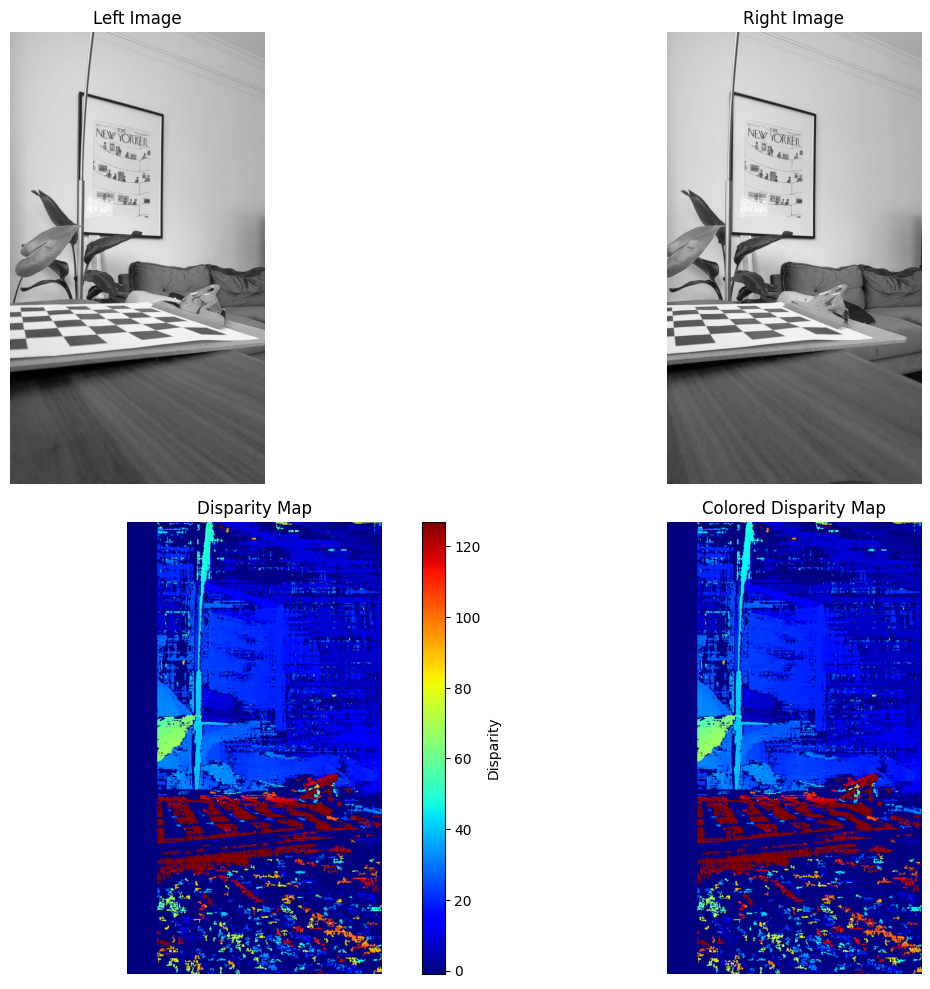

Disparity statistics:
Min disparity: 0.56
Max disparity: 127.00
Mean disparity: 35.39
Valid pixels: 961052 out of 2073600


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize

def load_test_images():
    # Load stereo images from scikit-image dataset
    image_left = data.stereo_motorcycle()[0]
    image_right = data.stereo_motorcycle()[1]
    
    # Convert to grayscale if needed
    if len(image_left.shape) == 3:
        image_left = rgb2gray(image_left)
        image_right = rgb2gray(image_right)
    
    # Convert to uint8 and proper range for OpenCV
    image_left = (image_left * 255).astype(np.uint8)
    image_right = (image_right * 255).astype(np.uint8)
    
    return image_left, image_right

def preprocess_images(left_img, right_img, scale_factor=1.0):
    # Resize images if needed
    if scale_factor != 1.0:
        width = int(left_img.shape[1] * scale_factor)
        height = int(left_img.shape[0] * scale_factor)
        dim = (width, height)
        left_img = cv2.resize(left_img, dim, interpolation=cv2.INTER_AREA)
        right_img = cv2.resize(right_img, dim, interpolation=cv2.INTER_AREA)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    left_img = clahe.apply(left_img)
    right_img = clahe.apply(right_img)
    
    return left_img, right_img

def compute_disparity_map(left_img, right_img):
    # Create StereoSGBM object
    window_size = 5
    min_disp = 0
    num_disp = 128
    
    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=window_size,
        P1=8 * 3 * window_size**2,
        P2=32 * 3 * window_size**2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # Compute disparity
    disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    
    return disparity

def main():
    try:
        # Load test images
        # left_img, right_img = load_test_images()
        left_img = cv2.imread("left_rectified.jpg", cv2.IMREAD_GRAYSCALE)
        right_img = cv2.imread("right_rectified.jpg", cv2.IMREAD_GRAYSCALE)
        # Crop images from left and right sides
        
        # Store original images
        original_left = left_img.copy()
        original_right = right_img.copy()
        
        # Preprocess images
        left_img, right_img = preprocess_images(left_img, right_img)
        
        # Compute disparity map
        disparity = compute_disparity_map(left_img, right_img)
        
        # Normalize disparity for visualization
        disparity_normalized = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        
        # Create color disparity map
        disparity_color = cv2.applyColorMap(disparity_normalized, cv2.COLORMAP_JET)
        
        # Visualize results
        plt.figure(figsize=(15, 10))
        
        plt.subplot(221)
        plt.imshow(original_left, cmap='gray')
        plt.title('Left Image')
        plt.axis('off')
        
        plt.subplot(222)
        plt.imshow(original_right, cmap='gray')
        plt.title('Right Image')
        plt.axis('off')
        
        plt.subplot(223)
        plt.imshow(disparity, cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title('Disparity Map')
        plt.axis('off')
        
        plt.subplot(224)
        plt.imshow(cv2.cvtColor(disparity_color, cv2.COLOR_BGR2RGB))
        plt.title('Colored Disparity Map')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics about the disparity map
        valid_disparities = disparity[disparity > 0]
        if len(valid_disparities) > 0:
            print(f"Disparity statistics:")
            print(f"Min disparity: {valid_disparities.min():.2f}")
            print(f"Max disparity: {valid_disparities.max():.2f}")
            print(f"Mean disparity: {valid_disparities.mean():.2f}")
            print(f"Valid pixels: {len(valid_disparities)} out of {disparity.size}")
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")

if __name__ == "__main__":
    main()

Image size: (500, 741)
Estimated focal length: 310.89 pixels
Using baseline: 35 mm


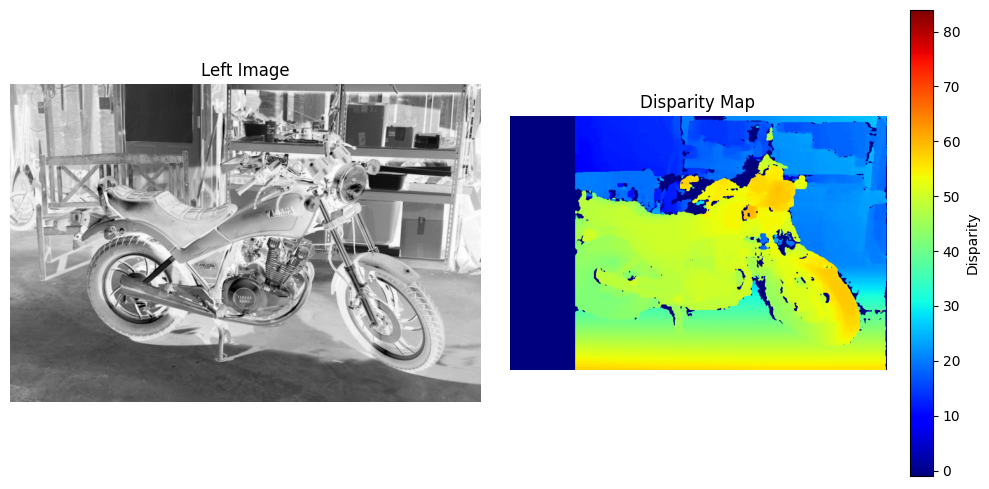

Displaying point cloud... Close the window to continue


2025-03-26 15:18:39.605 python[57151:3913568] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-26 15:18:39.605 python[57151:3913568] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import open3d as o3d

def load_test_images():
    # Load stereo images from scikit-image dataset
    image_left = data.stereo_motorcycle()[0]
    image_right = data.stereo_motorcycle()[1]
    
    if len(image_left.shape) == 3:
        image_left = cv2.cvtColor(image_left, cv2.COLOR_RGB2GRAY)
        image_right = cv2.cvtColor(image_right, cv2.COLOR_RGB2GRAY)
    
    # Convert to uint8
    image_left = (image_left * 255).astype(np.uint8)
    image_right = (image_right * 255).astype(np.uint8)
    
    return image_left, image_right

def compute_disparity_map(left_img, right_img):
    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,
        blockSize=5,
        P1=8 * 3 * 5**2,
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    return disparity

def create_point_cloud(disparity, left_img, baseline, focal_length):
    """
    Create point cloud from disparity map
    baseline: camera baseline in mm
    focal_length: focal length in pixels
    """
    h, w = disparity.shape
    
    # Create grid of image coordinates
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Calculate depth (Z)
    Z = np.zeros_like(disparity)
    mask = disparity > 0
    Z[mask] = (focal_length * baseline) / disparity[mask]
    
    # Calculate X and Y coordinates
    X = (x - w/2) * Z / focal_length
    Y = (y - h/2) * Z / focal_length
    
    # Create point cloud
    points = np.stack([X, Y, Z], axis=-1)
    colors = np.zeros_like(points)
    
    # Add colors if available
    if len(left_img.shape) == 2:
        colors[..., :] = left_img[..., np.newaxis] / 255.0
    else:
        colors = left_img / 255.0
    
    # Filter out invalid points
    valid_mask = (Z > 0) & (Z < 10000)  # Filter out points too far or too close
    points = points[valid_mask]
    colors = colors[valid_mask]
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Remove statistical outliers
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
    
    return pcd

def main():
    try:
        # Load images
        left_img, right_img = load_test_images()

        # left_img = cv2.imread('left_rectified.jpg', cv2.IMREAD_COLOR)
        # right_img = cv2.imread('right_rectified.jpg', cv2.IMREAD_COLOR)
        print(f"Image size: {left_img.shape}")
        
        # Compute disparity
        disparity = compute_disparity_map(left_img, right_img)
        
        # Estimate camera parameters (these are approximate values for the dataset)
        # In real applications, these should come from camera calibration
        image_width = left_img.shape[1]
        fov = 100  # degrees (assumed)
        focal_length_pixels = (image_width/2) / np.tan(np.radians(fov/2))
        baseline = 35  # mm (assumed distance between cameras)
        
        print(f"Estimated focal length: {focal_length_pixels:.2f} pixels")
        print(f"Using baseline: {baseline} mm")
        
        # Create point cloud
        pcd = create_point_cloud(disparity, left_img, baseline, focal_length_pixels)
        
        # Visualize results
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.imshow(left_img, cmap='gray')
        plt.title('Left Image')
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(disparity, cmap='jet')
        plt.colorbar(label='Disparity')
        plt.title('Disparity Map')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Visualize point cloud
        print("Displaying point cloud... Close the window to continue")
        o3d.visualization.draw_geometries([pcd])
        
        # Optionally save the point cloud
        o3d.io.write_point_cloud("stereo_reconstruction.ply", pcd)
        print("Point cloud saved as 'stereo_reconstruction.ply'")
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")

if __name__ == "__main__":
    main()

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

class StereoCalibrator:
    def __init__(self, checkerboard_size=(9,6), square_size=24.0):
        """
        Initialize calibrator
        checkerboard_size: interior number of corners (width, height)
        square_size: size of a square in millimeters
        """
        self.checkerboard_size = checkerboard_size
        self.square_size = square_size
        self.criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        # Prepare object points
        self.objp = np.zeros((checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
        self.objp[:,:2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1,2)
        self.objp *= square_size
        
        # Arrays to store object points and image points
        self.objpoints = []  # 3D points in real world space
        self.left_imgpoints = []  # 2D points in left image plane
        self.right_imgpoints = []  # 2D points in right image plane
        
    def find_checkerboard_corners(self, img):
        """Find checkerboard corners in an image"""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
        ret, corners = cv2.findChessboardCorners(gray, self.checkerboard_size, None)
        
        if ret:
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), self.criteria)
            return True, corners2
        return False, None
    
    def calibrate_cameras(self, left_images, right_images):
        """Calibrate cameras using pairs of images"""
        print("Starting calibration...")
        img_shape = None
        
        for left_img, right_img in zip(left_images, right_images):
            if img_shape is None:
                img_shape = left_img.shape[:2]
            
            # Find corners in both images
            left_ret, left_corners = self.find_checkerboard_corners(left_img)
            right_ret, right_corners = self.find_checkerboard_corners(right_img)
            
            if left_ret and right_ret:
                self.objpoints.append(self.objp)
                self.left_imgpoints.append(left_corners)
                self.right_imgpoints.append(right_corners)
                
                # Draw and display corners (optional)
                cv2.drawChessboardCorners(left_img, self.checkerboard_size, left_corners, left_ret)
                cv2.drawChessboardCorners(right_img, self.checkerboard_size, right_corners, right_ret)
                
                # Show the images
                plt.figure(figsize=(12,5))
                plt.subplot(121)
                plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
                plt.title('Left Image Corners')
                plt.subplot(122)
                plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
                plt.title('Right Image Corners')
                plt.show()
        
        print(f"Found {len(self.objpoints)} valid image pairs for calibration")
        
        # Calibrate each camera individually
        ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(
            self.objpoints, self.left_imgpoints, img_shape, None, None)
        ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(
            self.objpoints, self.right_imgpoints, img_shape, None, None)
        
        # Stereo calibration
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        
        ret, mtx_left, dist_left, mtx_right, dist_right, R, T, E, F = cv2.stereoCalibrate(
            self.objpoints, self.left_imgpoints, self.right_imgpoints,
            mtx_left, dist_left, mtx_right, dist_right, img_shape,
            flags=flags, criteria=self.criteria)
        
        # Compute rectification transforms
        R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
            mtx_left, dist_left, mtx_right, dist_right, img_shape, R, T)
        
        # Compute rectification maps
        self.left_map1, self.left_map2 = cv2.initUndistortRectifyMap(
            mtx_left, dist_left, R1, P1, img_shape, cv2.CV_32FC1)
        self.right_map1, self.right_map2 = cv2.initUndistortRectifyMap(
            mtx_right, dist_right, R2, P2, img_shape, cv2.CV_32FC1)
        
        return ret
    
    def rectify_images(self, left_img, right_img):
        """Rectify a pair of images using the calibration results"""
        left_rectified = cv2.remap(left_img, self.left_map1, self.left_map2, cv2.INTER_LINEAR)
        right_rectified = cv2.remap(right_img, self.right_map1, self.right_map2, cv2.INTER_LINEAR)
        return left_rectified, right_rectified
    
    def draw_epipolar_lines(self, left_img, right_img, interval=50):
        """Draw epipolar lines on rectified images"""
        height = left_img.shape[0]
        left_lines = left_img.copy()
        right_lines = right_img.copy()
        
        for y in range(0, height, interval):
            color = (0, 255, 0)  # Green color for lines
            cv2.line(left_lines, (0, y), (left_img.shape[1], y), color, 1)
            cv2.line(right_lines, (0, y), (right_img.shape[1], y), color, 1)
            
        return left_lines, right_lines

def main():
    # Initialize calibrator
    calibrator = StereoCalibrator(checkerboard_size=(9,6), square_size=24.0)
    
    # Load calibration images
    left_cal_images = []
    right_cal_images = []
    
    # Replace these paths with your calibration image paths
    left_cal_paths = sorted(glob.glob('calibration/left/*.jpg'))
    right_cal_paths = sorted(glob.glob('calibration/right/*.jpg'))
    
    for left_path, right_path in zip(left_cal_paths, right_cal_paths):
        left_img = cv2.imread(left_path)
        right_img = cv2.imread(right_path)
        if left_img is not None and right_img is not None:
            left_cal_images.append(left_img)
            right_cal_images.append(right_img)
    
    # Perform calibration
    ret = calibrator.calibrate_cameras(left_cal_images, right_cal_images)
    print(f"Calibration {'successful' if ret else 'failed'}")
    
    # Load and rectify a pair of images
    left_img = cv2.imread('left_image.jpg')
    right_img = cv2.imread('right_image.jpg')
    
    if left_img is not None and right_img is not None:
        # Rectify images
        left_rectified, right_rectified = calibrator.rectify_images(left_img, right_img)
        
        # Draw epipolar lines
        left_lines, right_lines = calibrator.draw_epipolar_lines(left_rectified, right_rectified)
        
        # Visualize results
        plt.figure(figsize=(15,10))
        
        plt.subplot(221)
        plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Left Image')
        
        plt.subplot(222)
        plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Right Image')
        
        plt.subplot(223)
        plt.imshow(cv2.cvtColor(left_lines, cv2.COLOR_BGR2RGB))
        plt.title('Rectified Left Image with Epipolar Lines')
        
        plt.subplot(224)
        plt.imshow(cv2.cvtColor(right_lines, cv2.COLOR_BGR2RGB))
        plt.title('Rectified Right Image with Epipolar Lines')
        
        plt.tight_layout()
        plt.show()
        
        # Save rectified images
        cv2.imwrite('left_rectified.jpg', left_rectified)
        cv2.imwrite('right_rectified.jpg', right_rectified)
        print("Rectified images saved")

if __name__ == "__main__":
    main()

Starting calibration...
Found 0 valid image pairs for calibration


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/calib3d/src/calibration.cpp:1379: error: (-215:Assertion failed) nimages > 0 in function 'calibrateCameraRO'
